<a href="https://colab.research.google.com/github/BuczynskiRafal/pipe_calculations/blob/main/Catchments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install extensions

In [1]:
!pip install pyswmm
!pip install swmmio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.2/101.2 KB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.4/459.4 KB 21.5 MB/s eta 0:00:00
  Created wheel for julian: filename=julian-0.14-py3-none-any.whl size=2633 sha256=a30bd50df52736f8b647bc3380b535f66d074ff86108ad36661897696cf637ba
  Stored in directory: /root/.cache/pip/wheels/bd/d6/58/f93bc5f95e521839cd07ea3d26f8b575a01c8a0318909e0041
Successfully built julian
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.4/291.4 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.4/215.4 KB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Import 

In [15]:
import os
import swmmio
import tempfile
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from swmmio.utils.dataframes import dataframe_from_inp
from swmmio.utils.text import get_inp_sections_details
from swmmio.utils.modify_model import replace_inp_section
from swmmio.version_control.utils import write_inp_section
from pyswmm import Simulation, Nodes, Links, Subcatchments, Output

# Prepare model for managing

In [6]:
#initialize a baseline model object
baseline = swmmio.Model('example.inp')
#create copy the base model 
newfilepath = os.path.join(baseline.inp.name + "_" + 'copy' + '.inp')
# save new file
baseline.inp.save(newfilepath)

# Explore model data

In [ ]:
model = swmmio.Model('example_copy.inp')
# df_subcatchments = dataframe_from_inp(model.inp.path, '[SUBCATCHMENTS]')
df_subcatchments = model.subcatchments.dataframe
df_subcatchments

In [ ]:
''' PySWMM doesn't allow to set percent imprevious parameter.
It's important to check impact this feature on runoff.
This is the reason to overide imprevious value in dataftame 
and overwrite model with new data.
'''
def overwrite_percent_imprevious(value: float, subcatchment_id: str, file_path: str = 'example_copy.inp') -> None:
    model = swmmio.Model(file_path)

    #create a dataframe of the model's subcatchments
    subcatchments = swmmio.utils.dataframes.dataframe_from_inp(model.inp.path, '[SUBCATCHMENTS]')

    # subcatchments = model.subcatchments.dataframe
    subcatchments.loc[subcatchment_id, "PercImperv"] = value

    #overwrite file with new data
    swmmio.utils.modify_model.replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)

# overwrite_percent_imprevious(value=50, subcatchment_id='S1', file_path='example_copy.inp')


In [ ]:
def calculate(subcatchment_id=None, conduit_id=None, file_path='example_copy.inp'):
    with Simulation(file_path) as sim:
        catchment = Subcatchments(sim)[subcatchment_id]
        conduit = Links(sim)[conduit_id]
        for _ in sim: pass
        return catchment.statistics, conduit.conduit_statistics
        

def simulate_catchment_features(subcatchment_id=None, conduit_id=None, min=1, max=100, step=10, file_path='example_copy.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    conduit_data = {'flow_turn_sign': [], 'flow_turns': [], 'peak_depth': [], 'peak_flow': [], 'peak_flow_date': [], 'peak_velocity': [], 'time_capacity_limited': [], 'time_courant_crit': [], 'time_full_downstream': [], 'time_full_flow': [], 'time_full_upstream': [], 'time_normal_flow': []}
    iterator = [min]
    counter = min
    while counter < max:
        counter += step
        iterator.append(counter)
    slope, percent_impervious, area = [], [], []
    for a in range(1, 16, 1):
        for s in iterator:
            for i in iterator:
                slope.append(s)
                percent_impervious.append(i)
                area.append(a)
                model = swmmio.Model(file_path)
                subcatchments = swmmio.utils.dataframes.dataframe_from_inp(file_path, '[SUBCATCHMENTS]')
                subcatchments.loc[subcatchment_id, "PercSlope"] = s/100
                subcatchments.loc[subcatchment_id, "PercImperv"] = i
                subcatchments.loc[subcatchment_id, "Area"] = a
                replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)
                catchment_stats = calculate(subcatchment_id=subcatchment_id,  conduit_id=conduit_id, file_path=model.inp.path)
                conduit_stats = conduit
                for key in catchment_data:
                    catchment_data[key].append(catchment_stats[key])
                counter += step
    catchment_data["slope"] = slope
    catchment_data["percent_impervious"] = percent_impervious
    catchment_data["area"] = area
    return pd.DataFrame(data=catchment_data)


In [ ]:
analyse = simulate_catchment_features(subcatchment_id='S1', min=1, max=100, step=10, file_path='example_copy.inp')

In [ ]:
analyse.head()

# Simulate percent imprevious feature 

## Prepare method for simulation

In [16]:
def simulate_percent_imprevious(subcatchment_id=None, min=0.1, max=100, step=10, file_path='example_copy.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    model = swmmio.Model(file_path)
    percent_impervious = []
    counter = min
    while counter < max:
        subcatchments = swmmio.utils.dataframes.dataframe_from_inp(model.inp.path, '[SUBCATCHMENTS]')
        subcatchments.loc[subcatchment_id, "PercImperv"] = counter
        percent_impervious.append(counter)
        replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)

        with Simulation(model.inp.path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            for _ in sim: pass
            catchment_stats = catchment.statistics          
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
        counter += step
    catchment_data["percent_impervious"] = percent_impervious
    return pd.DataFrame(data=catchment_data)

## Get imprevious data

In [17]:
df_percent_imprevious =  simulate_percent_imprevious(subcatchment_id='S1', min=1, max=100, step=1, file_path='example_copy.inp')

In [18]:
df_percent_imprevious[:11]

,runoff,peak_runoff_rate,infiltration,evaporation,percent_impervious
0,3850.531592,0.254118,469.913677,0.0,1
1,3862.550429,0.254544,464.889640,0.0,2
2,3874.469219,0.254970,459.869551,0.0,3
3,3886.283404,0.255390,454.853440,0.0,4
4,3898.001121,0.255807,449.841333,0.0,5
5,3909.625989,0.256220,444.833262,0.0,6
6,3921.162349,0.256630,439.829254,0.0,7
7,3932.612364,0.257035,434.829340,0.0,8
8,3943.978926,0.257438,429.833550,0.0,9
9,3955.263328,0.257836,424.841916,0.0,10


In [19]:
df_percent_imprevious.shape

(99, 5)

## Subcatchments data output


In [76]:
# font = {
#     # 'family' : 'normal',
#     # 'weight' : 'bold',
#     'size'   : 18
#     }

# matplotlib.rc('font', **font)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE, weight='normal')          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

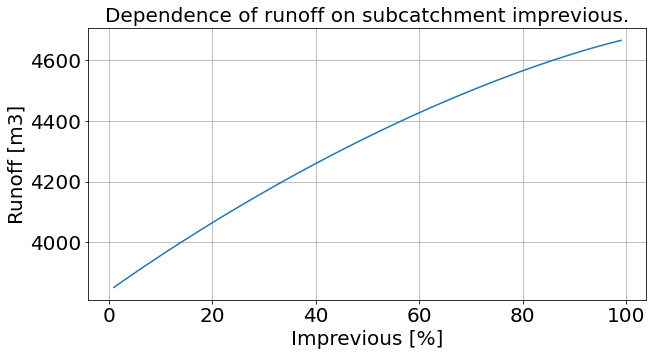

In [77]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_percent_imprevious['percent_impervious'], df_percent_imprevious['runoff'])
plt.title('Dependence of runoff on subcatchment imprevious.')
plt.xlabel('Imprevious [%]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment imprevious.


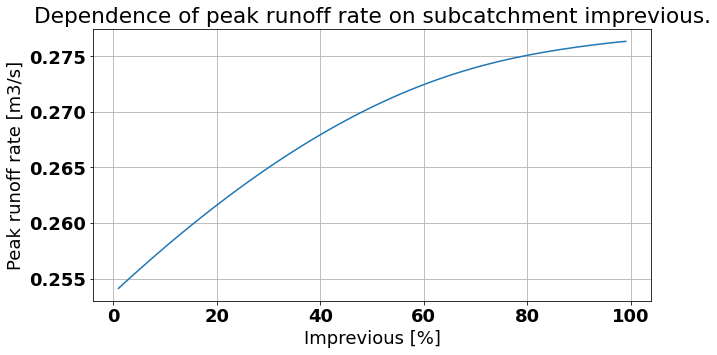

In [40]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_percent_imprevious['percent_impervious'], df_percent_imprevious['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment imprevious.')
plt.xlabel('Imprevious [%]')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment imprevious


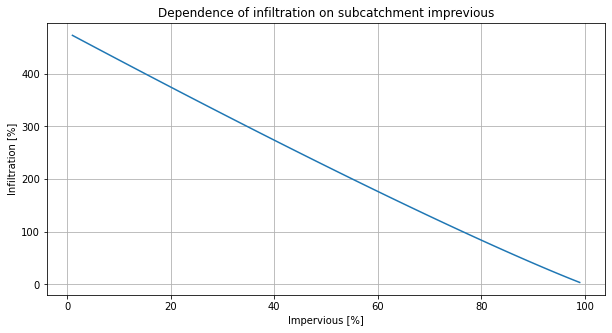

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_percent_imprevious['percent_impervious'], df_percent_imprevious['infiltration'])
plt.title('Dependence of infiltration on subcatchment imprevious.')
plt.xlabel('Impervious [%]')
plt.ylabel('Infiltration [m3]')
plt.grid(True)
plt.show()

# Simulate percent slope feature

## Prepare methoed for analyse slope

In [ ]:
def simulate_catchments_slope(subcatchment_id=None, conduit_id=None, min=1, max=100, step=1, file_path='example.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    conduit_data = {'flow_turn_sign': [], 'flow_turns': [], 'peak_depth': [], 'peak_flow': [], 'peak_flow_date': [], 'peak_velocity': [], 'time_capacity_limited': [], 'time_courant_crit': [], 'time_full_downstream': [], 'time_full_flow': [], 'time_full_upstream': [], 'time_normal_flow': []}
    slope = []
    counter = min
    while counter < max:
        with Simulation(file_path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            conduit = Links(sim)[conduit_id]
            catchment.slope = counter/100
            for _ in sim:
                pass
            catchment_stats = catchment.statistics
            conduit_stats = conduit.conduit_statistics
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
            for key in conduit_data:
                conduit_data[key].append(conduit_stats[key])
            slope.append(counter)
        counter += step
    catchment_data["slope"] = slope
    return pd.DataFrame(data={**catchment_data, **conduit_data})

## Get slope data

In [ ]:
df_slope = simulate_catchments_slope("S1", "C3")

In [ ]:
df_slope.head()

,runoff,peak_runoff_rate,...,time_full_upstream,time_normal_flow
0,3639.815161,0.214469,...,0.0,0.0
1,3834.420741,0.227808,...,0.0,0.0
2,3930.721094,0.234398,...,0.0,0.0
3,3991.742765,0.238596,...,0.0,0.0
4,4035.171965,0.241609,...,0.0,0.0


## Subcatchment data output

In [ ]:
# read dataset
df = df_slope.copy()
# get correlations
df_corr = df.corr()
# irrelevant fields
fields = ['time_full_flow', 'time_normal_flow', 'peak_velocity', 'peak_flow_date', 'peak_flow', 'peak_depth', 'flow_turn_sign', 'flow_turns', 'time_capacity_limited', 'time_courant_crit', 'time_full_downstream', 'time_full_upstream', 'evaporation']
# drop rows
df_corr.drop(fields, inplace=True)
# drop cols
df_corr.drop(fields, axis=1, inplace=True)

fig, ax = plt.subplots(figsize=(10, 8))
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# color map
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".1%", 
           linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)
# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)
# title
title = 'CORRELATION MATRIX\nSAMPLED CEREALS COMPOSITION\n'
plt.title(title, loc='left', fontsize=18)
plt.show()

### Dependence of runoff on subcatchment slope.

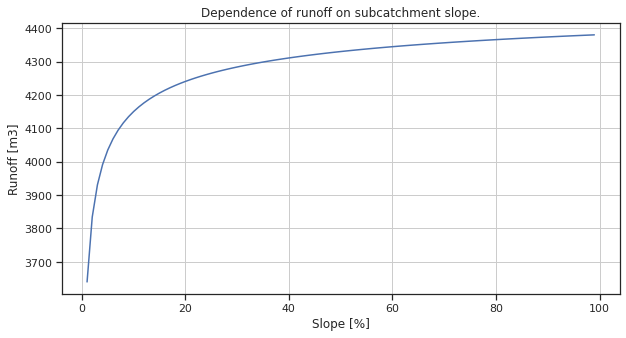

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['runoff'])
plt.title('Dependence of runoff on subcatchment slope.')
plt.xlabel('Slope [%]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment slope

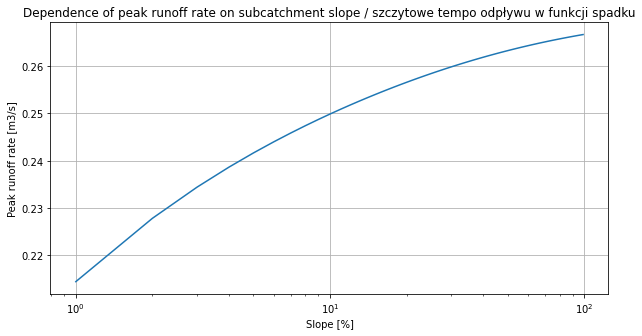

In [ ]:
plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment slope / szczytowe tempo odpływu w funkcji spadku')
plt.xlabel('Slope [%]')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment slope

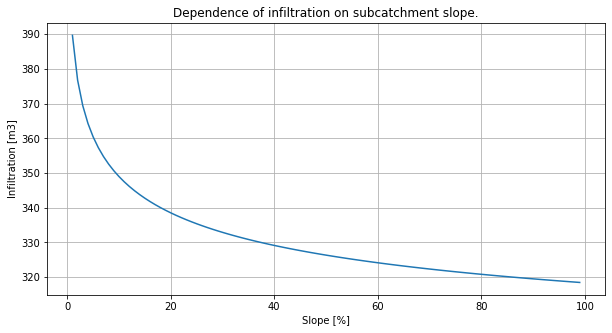

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['infiltration'])
plt.title('Dependence of infiltration on subcatchment slope.')
plt.xlabel('Slope [%]')
plt.ylabel('Infiltration [m3]')
plt.grid(True)
plt.show()

### Dependence of maximal flow on subcatchment slope.

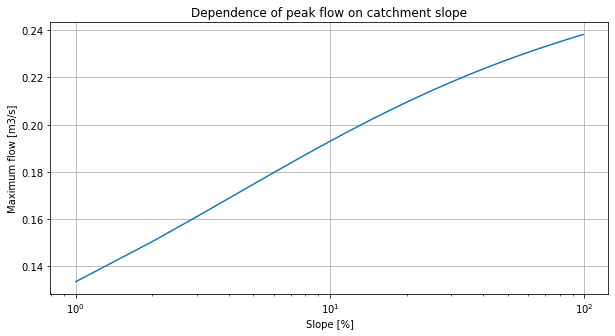

In [ ]:
# maksymaly przepływ [m3/s] w funkcji spadku terenu zlewni.
plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['peak_flow'])
plt.title('Dependence of peak flow on catchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Maximum flow [m3/s]')
plt.grid(True)
plt.show()

### Dependence of maximal velocity on subcatchment slope


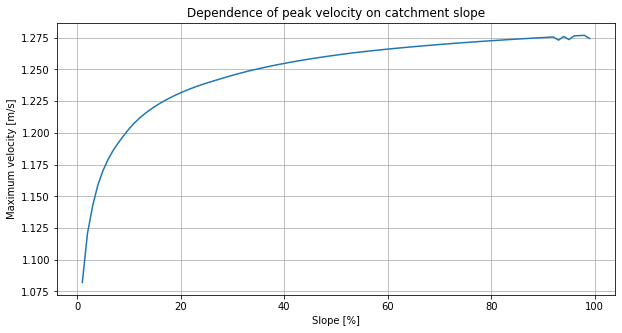

In [ ]:
# peak_velocity - maksymalna prędkość przepływu [m/s]
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['peak_velocity'])
plt.title('Dependence of peak velocity on catchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Maximum velocity [m/s]')
plt.grid(True)
plt.show()

### Dependence of maximal pipe filling on subcatchment slope.

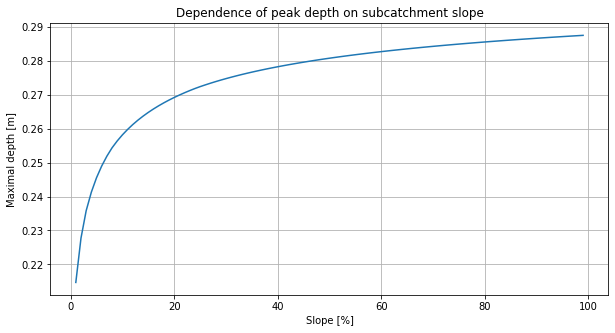

In [ ]:
# maksymalna wysokość napełnienia kanału  w sunkcji spadku terenu zlewni [m]
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['peak_depth'])
plt.title('Dependence of peak depth on subcatchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Maximal depth [m]')
plt.grid(True)
plt.show()

# Simulate N-Imperv (Mannings N for imprevious area)

### Description for N-Imperv value
Source: McCuen, R. et al. (1996), Hydrology, FHWA-SA-96-067, Federal Highway Administration, Washington, DC.


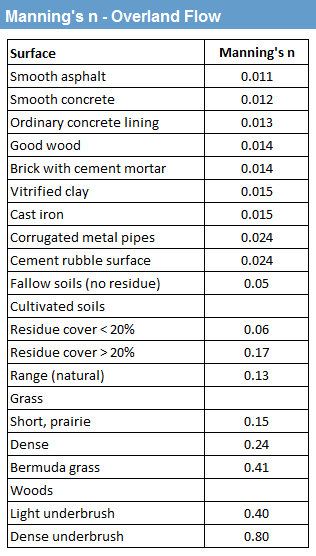


## Prepare method for simulation

In [ ]:
def simulate_n_imprev(subcatchment_id=None, file_path='example_copy.inp'):
    minings_n = np.sort([0.011, 0.012, 0.013, 0.014, 0.015, 0.024, 0.05, 0.06, 0.17, 0.13, 0.15, 0.24, 0.41, 0.4, 0.8])
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    percent_impervious = []
    model = swmmio.Model(file_path)
    for n in minings_n:
        subareas = model.inp.subareas
        subareas.loc["S1", "N-Imperv"] = n
        model.inp.subareas = subareas
        replace_inp_section(model.inp.path, '[SUBAREAS]', subareas)

        with Simulation(model.inp.path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            for _ in sim: pass
            catchment_stats = catchment.statistics          
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
    df = pd.DataFrame(data=catchment_data)
    df["N-Imperv"] = minings_n
    return df

## Get N-Impervious data

In [ ]:
df_n_impervious = simulate_n_imprev("S1")

In [ ]:
df_n_impervious.shape
df_n_impervious.head()

,runoff,peak_runoff_rate,infiltration,evaporation,N-Imperv
0,4163.388455,0.249798,348.967257,0.0,0.011
1,4163.239420,0.249793,348.967257,0.0,0.012
2,4163.090167,0.249788,348.967257,0.0,0.013
3,4162.968184,0.249800,348.967257,0.0,0.014
4,4162.838915,0.249804,348.967257,0.0,0.015


## Subcatchment data output

### Dependence of runoff on subcatchment imprevious.

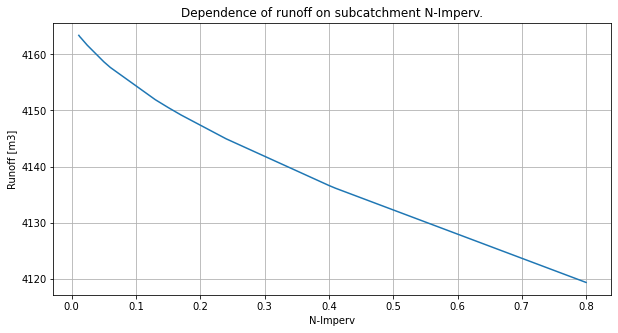

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_n_impervious['N-Imperv'], df_n_impervious['runoff'])
plt.title('Dependence of runoff on subcatchment N-Imperv.')
plt.xlabel('N-Imperv')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment imprevious.

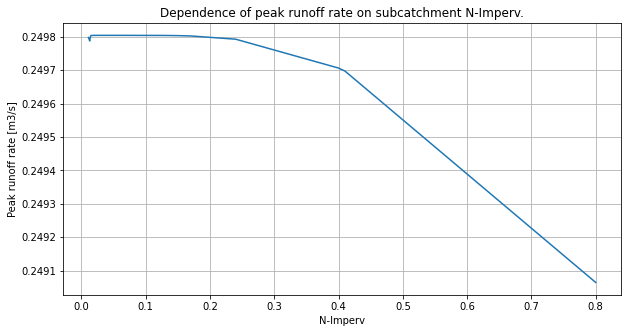

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_n_impervious['N-Imperv'], df_n_impervious['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment N-Imperv.')
plt.xlabel('N-Imperv')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment imprevious

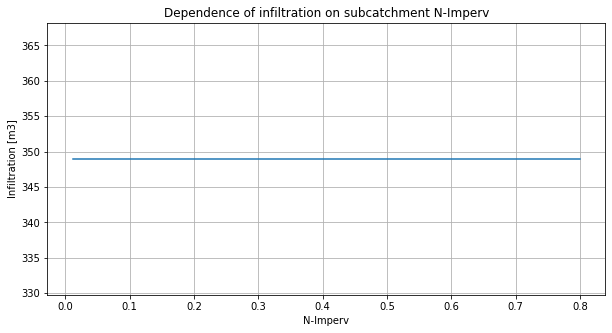

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_n_impervious['N-Imperv'], df_n_impervious['infiltration'])
plt.title('Dependence of infiltration on subcatchment N-Imperv.')
plt.xlabel('N-Imperv')
plt.ylabel('Infiltration [m3]')
plt.grid(True)
plt.show()

# Simulate N-Perv (Mannings N for revious area)

## Description
Source: McCuen, R. et al. (1996), Hydrology, FHWA-SA-96-067, Federal Highway Administration, Washington, DC.



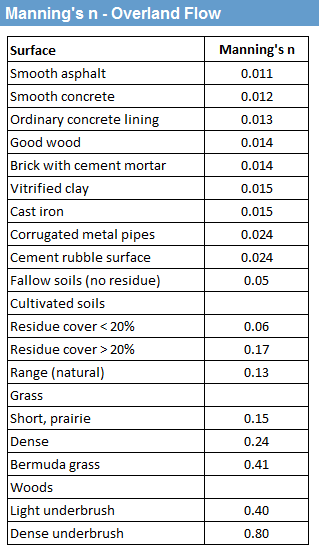

## Prepare method for simulation

In [ ]:
def simulate_n_prev(subcatchment_id=None, file_path='example_copy.inp'):
    minings_n = np.sort([0.011, 0.012, 0.013, 0.014, 0.015, 0.024, 0.05, 0.06, 0.17, 0.13, 0.15, 0.24, 0.41, 0.4, 0.8])
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    percent_impervious = []
    model = swmmio.Model(file_path)
    for n in minings_n:
        subareas = model.inp.subareas
        subareas.loc["S1", "N-Perv"] = n
        model.inp.subareas = subareas
        replace_inp_section(model.inp.path, '[SUBAREAS]', subareas)

        with Simulation(model.inp.path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            for _ in sim: pass
            catchment_stats = catchment.statistics          
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
    df = pd.DataFrame(data=catchment_data)
    df["N-Perv"] = minings_n
    return df

## Get N-Previous data

In [ ]:
df_n_perv = simulate_n_prev("S1")

In [ ]:
df_n_perv.shape
df_n_perv.head()

,runoff,peak_runoff_rate,infiltration,evaporation,N-Perv
0,4541.635107,0.271508,281.397246,0.0,0.011
1,4540.283556,0.271494,281.763873,0.0,0.012
2,4538.971740,0.271481,282.117137,0.0,0.013
3,4537.688825,0.271468,282.458438,0.0,0.014
4,4536.442847,0.271455,282.788963,0.0,0.015


## Subcatchments data output

### Dependence of runoff on subcatchment N-Perv.


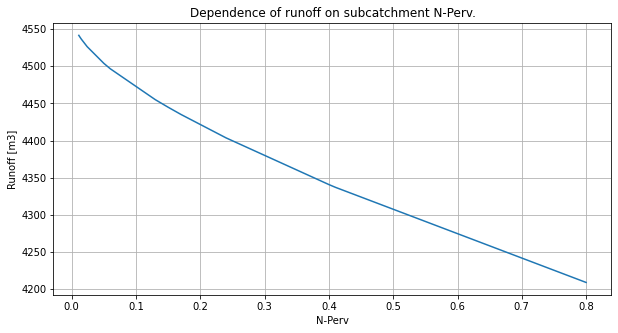

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_n_perv['N-Perv'], df_n_perv['runoff'])
plt.title('Dependence of runoff on subcatchment N-Perv.')
plt.xlabel('N-Perv')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment N-Perv.

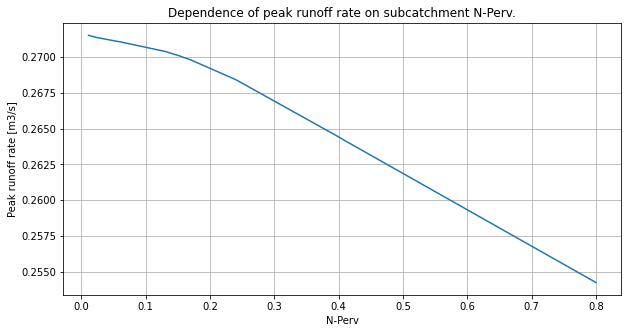

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_n_perv['N-Perv'], df_n_perv['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment N-Perv.')
plt.xlabel('N-Perv')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment imprevious

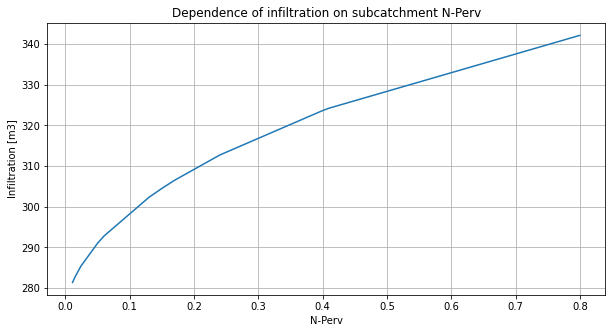

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_n_perv['N-Perv'], df_n_perv['infiltration'])
plt.title('Dependence of infiltration on subcatchment N-Perv.')
plt.xlabel('N-Perv')
plt.ylabel('Infiltration [m3]')
plt.grid(True)
plt.show()

# Simulate Destore-Imperv (Depth of depression storage on imprevious area [mm])

## Description
Source: ASCE,(1992), Design & Construction of Urban Stormwater Management Systems, New York, NY.

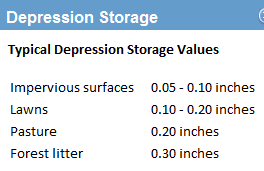



## Prepare method for simulation

In [ ]:
def simulate_s_imprev(subcatchment_id=None, file_path='example_copy.inp'):
    typical_values = np.sort([0.05, 0.1, 0.2, 0.3])
    typical_values = [val * 25.4 for val in typical_values]
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    model = swmmio.Model(file_path)
    for n in typical_values:
        subareas = model.inp.subareas
        subareas.loc["S1", "S-Imperv"] = n
        model.inp.subareas = subareas
        replace_inp_section(model.inp.path, '[SUBAREAS]', subareas)

        with Simulation(model.inp.path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            for _ in sim: pass
            catchment_stats = catchment.statistics          
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
    df = pd.DataFrame(data=catchment_data)
    df["Destore-Imperv"] = typical_values
    return df

## Get Destore-Imperv data

In [ ]:
df_s_imperv = simulate_s_imprev("S1")

In [ ]:
df_s_imperv.shape
df_s_imperv.head()

,runoff,peak_runoff_rate,infiltration,evaporation,Destore-Imperv
0,3831.152718,0.248009,379.001845,0.0,1.27
1,3823.226349,0.248009,379.001845,0.0,2.54
2,3807.373161,0.248009,379.001845,0.0,5.08
3,3791.486443,0.248009,379.001845,0.0,7.62


## Subcatchments data output

### Dependence of runoff on subcatchment Destore-Imperv.


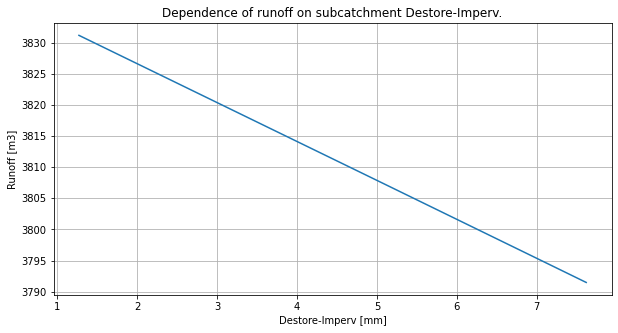

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_s_imperv['Destore-Imperv'], df_s_imperv['runoff'])
plt.title('Dependence of runoff on subcatchment Destore-Imperv.')
plt.xlabel('Destore-Imperv [mm]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment Destore-Imperv.

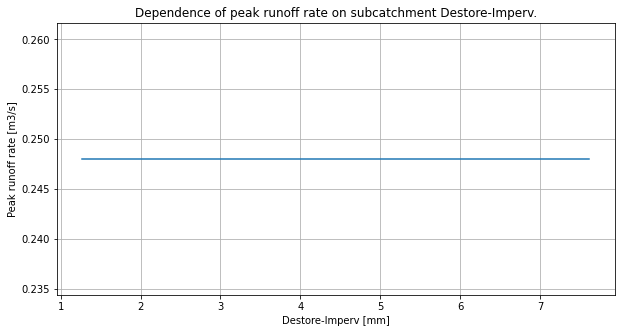

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_s_imperv['Destore-Imperv'], df_s_imperv['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment Destore-Imperv.')
plt.xlabel('Destore-Imperv [mm]')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment Destore-Imperv

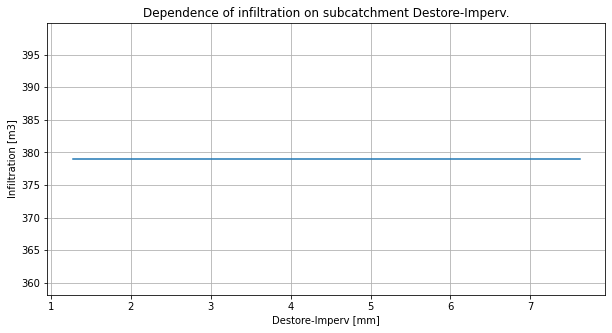

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_s_imperv['Destore-Imperv'], df_s_imperv['infiltration'])
plt.title('Dependence of infiltration on subcatchment Destore-Imperv.')
plt.xlabel('Destore-Imperv [mm]')
plt.ylabel('Infiltration [m3]')
plt.grid(True)
plt.show()

# Simulate Destore-Perv (Depth of depression storage on Previous area [mm])

## Description
Source: ASCE,(1992), Design & Construction of Urban Stormwater Management Systems, New York, NY.

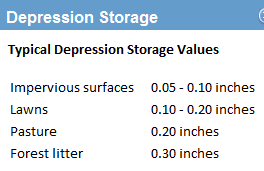



## Prepare method for simulation

In [ ]:
def simulate_s_prev(subcatchment_id=None, file_path='example_copy.inp'):
    typical_values = np.sort([0.05, 0.1, 0.2, 0.3])
    typical_values = [val * 25.4 for val in typical_values]
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    model = swmmio.Model(file_path)
    for n in typical_values:
        subareas = model.inp.subareas
        subareas.loc["S1", "S-Perv"] = n
        model.inp.subareas = subareas
        replace_inp_section(model.inp.path, '[SUBAREAS]', subareas)

        with Simulation(model.inp.path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            for _ in sim: pass
            catchment_stats = catchment.statistics          
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
    df = pd.DataFrame(data=catchment_data)
    df["Destore-Perv"] = typical_values
    return df

## Get Destore-Imperv data

In [ ]:
df_s_perv = simulate_s_prev("S1")

In [ ]:
df_s_perv.shape
df_s_perv.head()

,runoff,peak_runoff_rate,infiltration,evaporation,Destore-Perv
0,4098.899419,0.249570,354.922189,0.0,1.27
1,4046.079865,0.249309,360.519569,0.0,2.54
2,3941.759953,0.248718,370.401736,0.0,5.08
3,3838.766924,0.248009,379.001845,0.0,7.62


## Subcatchments data output

### Dependence of runoff on subcatchment Destore-Imperv.


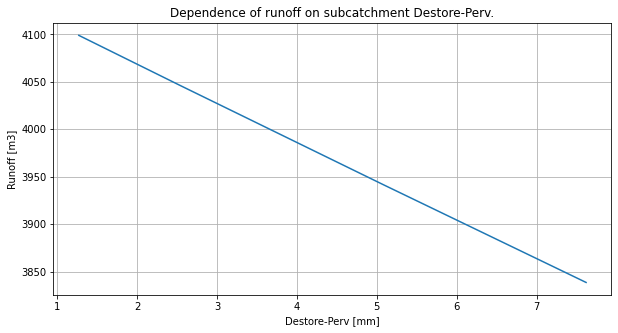

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_s_perv['Destore-Perv'], df_s_perv['runoff'])
plt.title('Dependence of runoff on subcatchment Destore-Perv.')
plt.xlabel('Destore-Perv [mm]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment Destore-Perv.

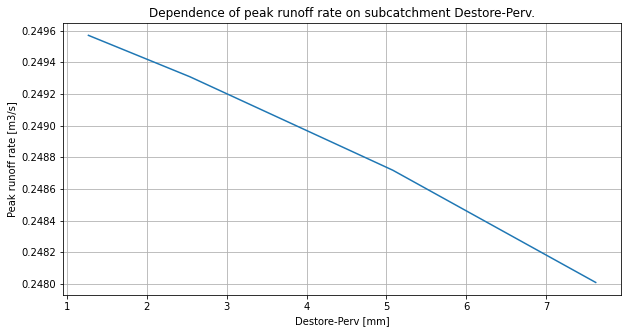

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_s_perv['Destore-Perv'], df_s_perv['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment Destore-Perv.')
plt.xlabel('Destore-Perv [mm]')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment Destore-Perv

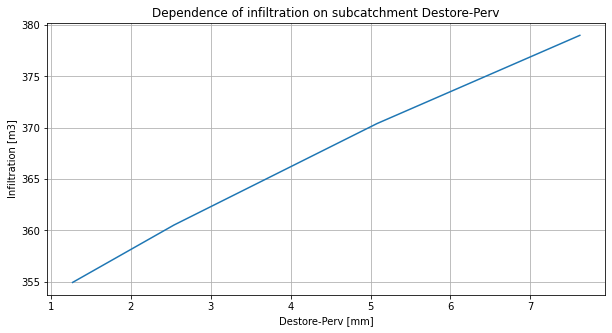

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_s_perv['Destore-Perv'], df_s_perv['infiltration'])
plt.title('Dependence of infiltration on subcatchment Destore-Perv.')
plt.xlabel('Destore-Perv [mm]')
plt.ylabel('Infiltration [m3]')
plt.grid(True)
plt.show()

# Simulate area feature

## Prepare method for simulation

In [ ]:
def simulate_catchments_area(subcatchment_id=None, conduit_id=None, min=1, max=100, step=1, file_path='example.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    area = []
    counter = min
    while counter < max:
        with Simulation(file_path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            conduit = Links(sim)[conduit_id]
            catchment.area = counter
            for _ in sim:
                pass
            catchment_stats = catchment.statistics
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
            area.append(counter)
        counter += step
    catchment_data["area"] = area
    return pd.DataFrame(data=catchment_data)

## Get area data

In [ ]:
df_area = simulate_catchments_area("S1", "C3")

In [ ]:
df_area.head()

,runoff,peak_runoff_rate,infiltration,evaporation,area
0,832.609431,0.049956,69.793451,0.0,1
1,1563.599855,0.092628,149.073088,0.0,2
2,2218.851346,0.130093,232.625443,0.0,3
3,2813.907451,0.163366,318.787792,0.0,4
4,3360.363166,0.193325,406.711636,0.0,5


## Subcatchments data output

### Dependence of runoff on subcatchment area.

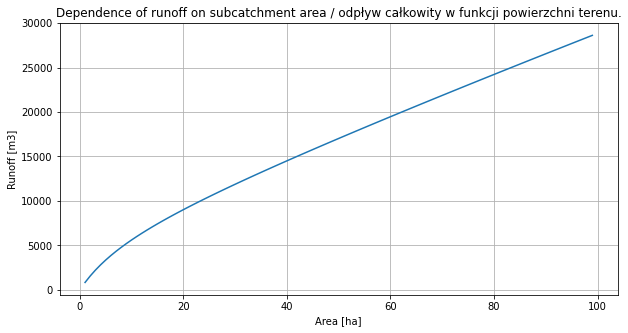

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_area['area'], df_area['runoff'])
plt.title('Dependence of runoff on subcatchment area / odpływ całkowity w funkcji powierzchni terenu.')
plt.xlabel('Area [ha]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment area.

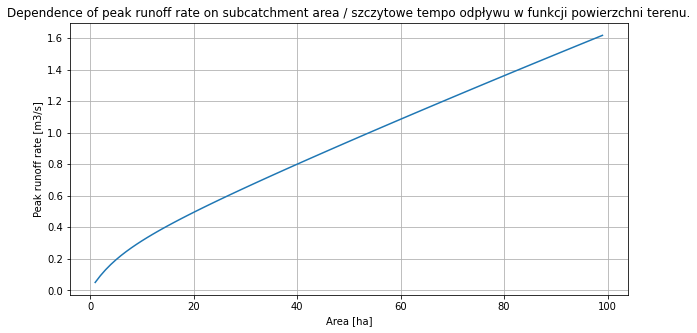

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_area['area'], df_area['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment area / szczytowe tempo odpływu w funkcji powierzchni terenu.')
plt.xlabel('Area [ha]')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment area.

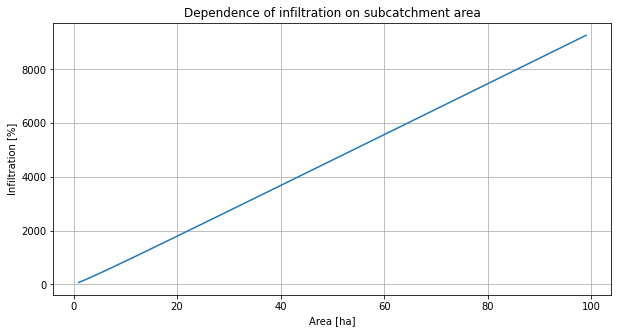

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_area['area'], df_area['infiltration'])
plt.title('Dependence of infiltration on subcatchment area')
plt.xlabel('Area [ha]')
plt.ylabel('Infiltration [m3]')
plt.grid(True)
plt.show()

# Simulate width feature

## Prepare method for simulation

In [ ]:
def simulate_catchments_width(subcatchment_id=None, conduit_id=None, min=1, max=1000, step=1, file_path='example_copy.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    width = []
    counter = min
    while counter < max:
        with Simulation(file_path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            conduit = Links(sim)[conduit_id]
            catchment.width = counter
            for _ in sim:
                pass
            catchment_stats = catchment.statistics
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
            width.append(counter)
        counter += step
    catchment_data["width"] = width
    return pd.DataFrame(data=catchment_data)

## Get area data

In [ ]:
df_width = simulate_catchments_width("S1", "C3")

In [ ]:
df_width.head()

,runoff,peak_runoff_rate,infiltration,evaporation,width
0,429.740919,0.029669,473.102313,0.0,1
1,686.436522,0.044216,471.815628,0.0,2
2,865.070335,0.053345,470.554765,0.0,3
3,1001.959867,0.061000,469.318863,0.0,4
4,1113.772324,0.067045,468.107098,0.0,5


## Subcatchments data output

### Dependence of runoff on subcatchment area.

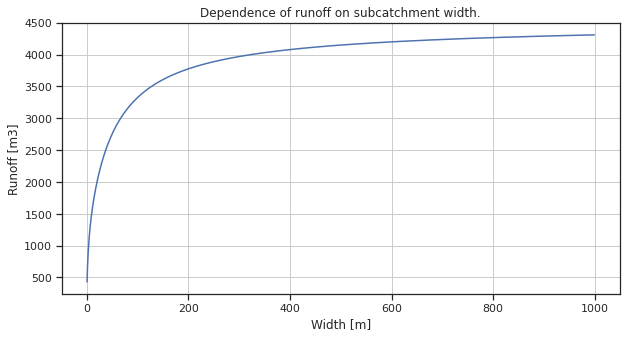

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_width['width'], df_width['runoff'])
plt.title('Dependence of runoff on subcatchment width.')
plt.xlabel('Width [m]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment area.

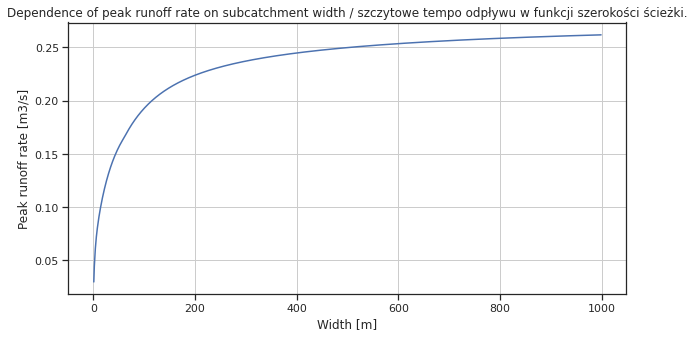

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_width['width'], df_width['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment width / szczytowe tempo odpływu w funkcji szerokości ścieżki.')
plt.xlabel('Width [m]')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment area.

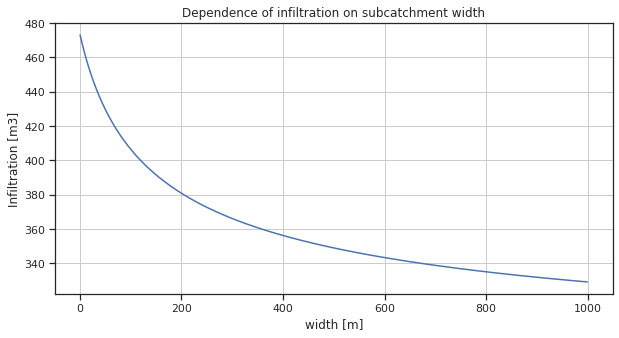

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_width['width'], df_width['infiltration'])
plt.title('Dependence of infiltration on subcatchment width.')
plt.xlabel('width [m]')
plt.ylabel('Infiltration [m3]')
plt.grid(True)
plt.show()

# Simulate Zero-Imperv (Percent of imprevious area with no depression storage [%])

## Prepare method for simulation

In [ ]:
def simulate_zero_imperv(subcatchment_id=None, step=1, file_path='example_copy.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    model = swmmio.Model(file_path)
    zero_imperv = []
    for p in range(0, 101, step):
        zero_imperv.append(p)
        subareas = model.inp.subareas
        subareas.loc["S1", "PctZero"] = p
        model.inp.subareas = subareas
        replace_inp_section(model.inp.path, '[SUBAREAS]', subareas)

        with Simulation(model.inp.path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            for _ in sim: pass
            catchment_stats = catchment.statistics          
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
    catchment_data["Zero-Imperv"] = zero_imperv
    return pd.DataFrame(data=catchment_data)

## Get Destore-Imperv data

In [ ]:
df_zero_imperv = simulate_zero_imperv("S1")

In [ ]:
df_zero_imperv.shape
df_zero_imperv

,runoff,peak_runoff_rate,infiltration,evaporation,Zero-Imperv
0,4149.896304,0.249804,348.967257,0.0,0
1,4149.902546,0.249804,348.967257,0.0,1
2,4149.908788,0.249804,348.967257,0.0,2
3,4149.915030,0.249804,348.967257,0.0,3
4,4149.921272,0.249804,348.967257,0.0,4
...,...,...,...,...,...
96,4150.495525,0.249804,348.967257,0.0,96
97,4150.501766,0.249804,348.967257,0.0,97
98,4150.508008,0.249804,348.967257,0.0,98
99,4150.514250,0.249804,348.967257,0.0,99


## Subcatchments data output

### Dependence of runoff on subcatchment Destore-Imperv.


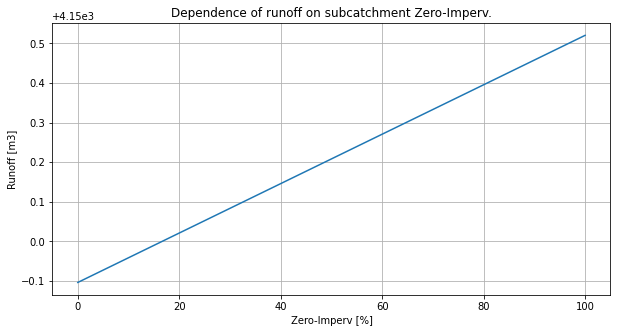

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_zero_imperv['Zero-Imperv'], df_zero_imperv['runoff'])
plt.title('Dependence of runoff on subcatchment Zero-Imperv.')
plt.xlabel('Zero-Imperv [%]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment Zero-Imperv.

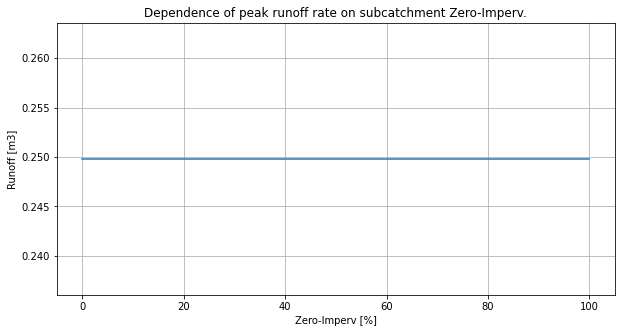

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_zero_imperv['Zero-Imperv'], df_zero_imperv['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment Zero-Imperv.')
plt.xlabel('Zero-Imperv [%]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment Zero-Imperv

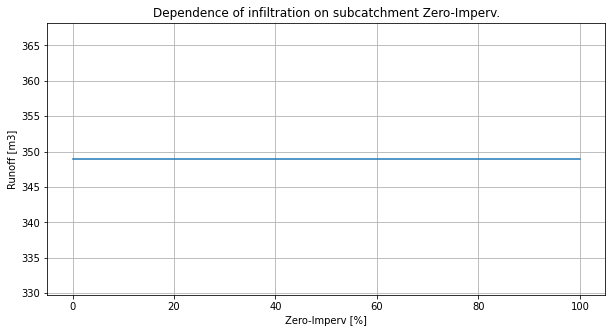

In [ ]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_zero_imperv['Zero-Imperv'], df_zero_imperv['infiltration'])
plt.title('Dependence of infiltration on subcatchment Zero-Imperv.')
plt.xlabel('Zero-Imperv [%]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

# Simulate all feature

## Prepare method for simulation

In [ ]:
def simulate_all_features(subcatchment_id=None, file_path='example_copy.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    model = swmmio.Model(file_path)
    subcatchments = model.inp.subcatchments
    subareas = model.inp.subareas
    # manning_n = np.sort([0.011, 0.012, 0.013, 0.014, 0.015, 0.024, 0.05, 0.06, 0.17, 0.13, 0.15, 0.24, 0.41, 0.4, 0.8])
    manning_n = np.sort([0.015, 0.05, 0.15, 0.24, 0.4, 0.8])
    # manning_n = np.sort([0.011, 0.012])
    # destore = np.array([0.05, 0.1, 0.2, 0.3])
    destore = np.array([0.1, 0.3])

    width = []
    slope = []
    curb_length = []
    n_imperv = []
    n_perv = []
    destore_iperv = []
    destore_perv = []
    zero_imperv = []
    for w in np.arange(100, 1000, 500):
        for s in np.arange(1, 100, 50):
            for cl in np.arange(100, 1000, 500):
                for n_i in manning_n:
                    for n_p in manning_n:
                        for di in destore:
                            for dp in destore:
                                for zi in np.arange(0, 100, 50):
                                    width.append(w)
                                    slope.append(s)
                                    curb_length.append(cl)
                                    n_imperv.append(n_i)
                                    n_perv.append(n_p)
                                    destore_iperv.append(di)
                                    destore_perv.append(dp)
                                    zero_imperv.append(zi)
                                    subcatchments = dataframe_from_inp(model.inp.path, '[SUBCATCHMENTS]')
                                    subcatchments.loc[subcatchment_id, ["Width", "PercSlope", "CurbLength"]] = [w, s, cl]
                                    subareas.loc[subcatchment_id, ["N-Imperv", "N-Perv", "S-Imperv", "S-Perv", "PctZero"]] = [n_i, n_p, di, dp, zi]
                                    replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)
                                    replace_inp_section(model.inp.path, '[SUBAREAS]', subareas)                   

                                    with Simulation(model.inp.path) as sim:
                                        catchment = Subcatchments(sim)[subcatchment_id]
                                        for _ in sim: pass
                                        catchment_stats = catchment.statistics          
                                        for key in catchment_data:
                                            catchment_data[key].append(catchment_stats[key])
                                print(f"dp: {dp}")
                    print(f"n_i: {n_i}")
                print(f"cl: {cl}")
            print(f"slope: {s}")
        print(f"Loop: {w}")
    df = pd.DataFrame(data=catchment_data)
    df["width"] = width
    df["percent_slope"] = slope
    df["percent_slope"] = slope
    df["curb_length"] = curb_length
    df["n_imperv"] = n_imperv
    df["n_perv"] = n_perv
    df["destore_iperv"] = destore_iperv
    df["destore_perv"] = destore_perv
    df["zero_imperv"] = zero_imperv
    return df

## Get features data

In [ ]:
w100 = pd.read_excel("w0.xlsx")
w250 = pd.read_excel("w250 (1).xlsx")
# w500 = pd.read_excel("w500.xlsx")
w750 = pd.read_excel("w750 (1).xlsx")
# w1000 = pd.read_excel("w1000.xlsx")

In [ ]:
w500 = pd.read_excel("w500.xlsx")


In [ ]:
# frames = [w100, w250, w500, w750, w1000]
frames = [w100, w250, w500, w750]

analyse = pd.concat(frames)

In [ ]:
# analyse = simulate_all_features("S1")
analyse.shape

(1304640, 14)

In [ ]:
analyse[:10]

,Unnamed: 0,runoff,...,zero_imperv,curb_length
0,0,0.0,...,0,NaN
1,1,0.0,...,20,NaN
2,2,0.0,...,40,NaN
3,3,0.0,...,60,NaN
4,4,0.0,...,80,NaN
5,5,0.0,...,0,NaN
6,6,0.0,...,20,NaN
7,7,0.0,...,40,NaN
8,8,0.0,...,60,NaN
9,9,0.0,...,80,NaN


In [ ]:
analyse.shape

(1304640, 13)

In [ ]:
analyse.to_excel('all_data.xlsx')

## Subcatchments data output

### Show feature correlations

In [ ]:
def simulate_all_features(subcatchment_id=None, file_path='example_copy.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    model = swmmio.Model(file_path)
    subcatchments = model.inp.subcatchments
    subareas = model.inp.subareas
    # manning_n = np.sort([0.011, 0.012, 0.013, 0.014, 0.015, 0.024, 0.05, 0.06, 0.17, 0.13, 0.15, 0.24, 0.41, 0.4, 0.8])
    manning_n = [0.015, 0.05, 0.15, 0.24, 0.4, 0.8]
    # manning_n = np.sort([0.011, 0.012])
    destore = [0.05, 0.1, 0.2, 0.3]
    # destore = np.array([0.1, 0.3])

    width = []
    slope = []
    percent_impervious = []
    n_imperv = []
    n_perv = []
    destore_iperv = []
    destore_perv = []
    zero_imperv = []
    for w in [500]:
        for s in range(0, 101, 10):
            for pi in range(0, 101, 10):
                for n_i in manning_n:
                    for n_p in manning_n:
                        for di in destore:
                            for dp in destore:
                                for zi in np.arange(0, 100, 20):
                                    width.append(w)
                                    slope.append(s)
                                    percent_impervious.append(pi)
                                    n_imperv.append(n_i)
                                    n_perv.append(n_p)
                                    destore_iperv.append(di)
                                    destore_perv.append(dp)
                                    zero_imperv.append(zi)
                                    subcatchments = dataframe_from_inp(model.inp.path, '[SUBCATCHMENTS]')
                                    subcatchments.loc[subcatchment_id, ["Width", "PercSlope", "CurbLength"]] = [w, s, pi]
                                    subareas.loc[subcatchment_id, ["N-Imperv", "N-Perv", "S-Imperv", "S-Perv", "PctZero"]] = [n_i, n_p, di, dp, zi]
                                    replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)
                                    replace_inp_section(model.inp.path, '[SUBAREAS]', subareas)                   

                                    with Simulation(model.inp.path) as sim:
                                        catchment = Subcatchments(sim)[subcatchment_id]
                                        for _ in sim: pass
                                        catchment_stats = catchment.statistics          
                                        for key in catchment_data:
                                            catchment_data[key].append(catchment_stats[key])
                                print(f"dp: {dp}")
                    print(f"n_i: {n_i}")
                    print(f"cl: {pi}")
                    print(f"slope: {s}")
                    print(f"Loop: {w}")
    df = pd.DataFrame(data=catchment_data)
    df["width"] = width
    df["percent_slope"] = slope
    df["percent_impervious"] = percent_impervious
    df["n_imperv"] = n_imperv
    df["n_perv"] = n_perv
    df["destore_iperv"] = destore_iperv
    df["destore_perv"] = destore_perv
    df["zero_imperv"] = zero_imperv
    return df

In [ ]:
analyse = pd.read_excel('data.xlsx')

In [ ]:
analyse[-5:]

,width,percent_slope,...,destore_perv,zero_imperv
77755,500,100,...,0.3,0
77756,500,100,...,0.3,20
77757,500,100,...,0.3,40
77758,500,100,...,0.3,60
77759,500,100,...,0.3,80


In [ ]:
analyse.drop(columns=['Unnamed: 0'], axis=1, inplace=True)


KeyError: ignored

In [ ]:
analyse.columns

Index(['width', 'percent_slope', 'percent_impervious', 'TotalInfil',
       'ImpervRunoff', 'PervRunoff', 'TotalRunoffMG', 'n_imperv', 'n_perv',
       'destore_iperv', 'destore_perv', 'zero_imperv'],
      dtype='object')

<ipython-input-109-2141287744aa>:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


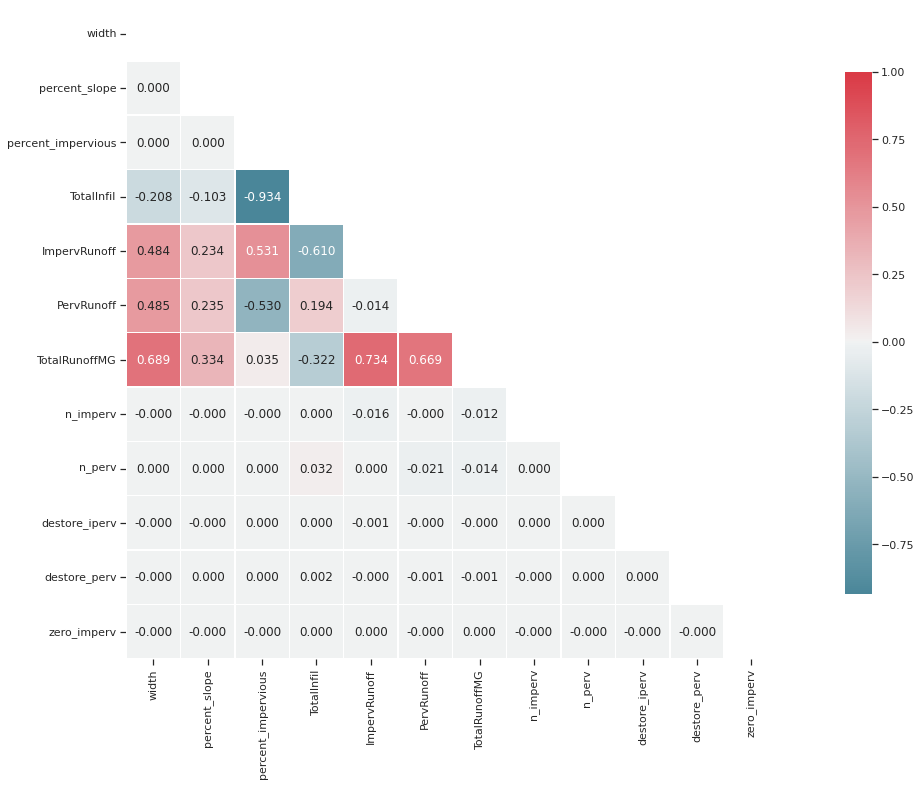

In [ ]:
df_corr = analyse.copy()
corr = df_corr.corr()
# fields = ['evaporation', 'peak_runoff_rate']
# drop rows
# corr.drop(fields, inplace=True)
# drop cols
# corr.drop(fields, axis=1, inplace=True)

sns.set(style="ticks")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(24, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt=".3f",
            square=True, linewidths=.5, cbar_kws={"shrink": 0.8})

<ipython-input-112-521ed465dea5>:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df_corr, dtype=np.bool))


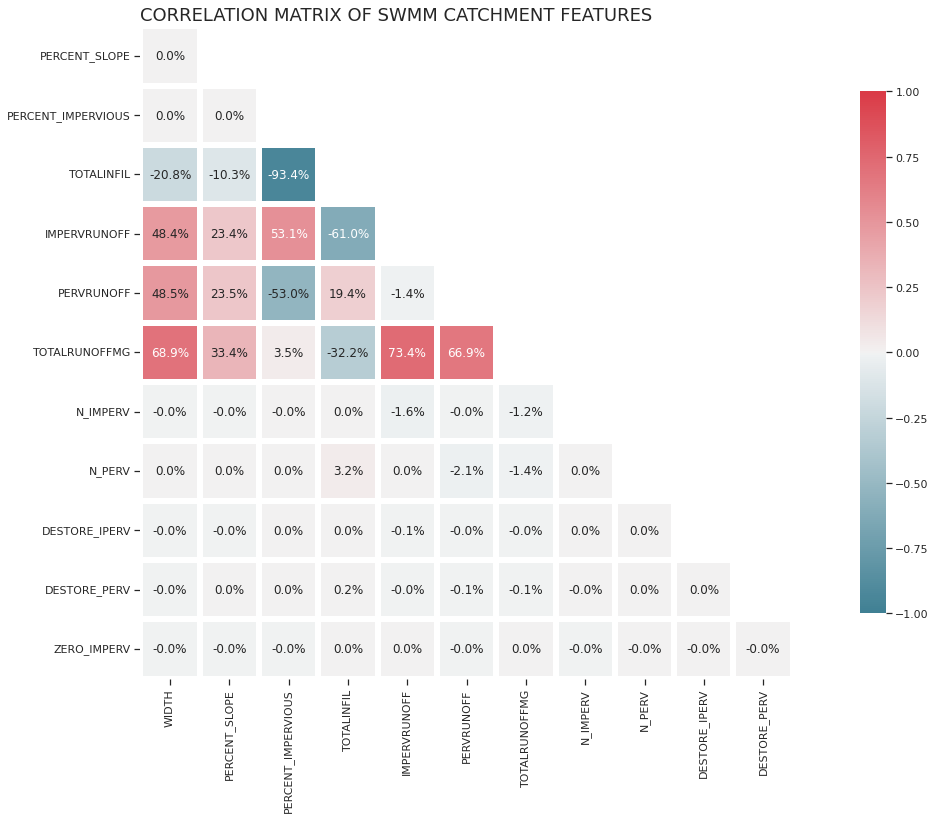

In [ ]:
# read dataset
df = analyse.copy()
# get correlations
df_corr = df.corr()
# irrelevant fields
# fields = ['evaporation', 'peak_runoff_rate']
# drop rows
# df_corr.drop(fields, inplace=True)
# drop cols
# df_corr.drop(fields, axis=1, inplace=True)

fig, ax = plt.subplots(figsize=(24, 12))
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# color map
# cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".1%", 
           linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)
# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)
# title
title = 'CORRELATION MATRIX OF SWMM CATCHMENT FEATURES'
plt.title(title, loc='left', fontsize=18)
plt.show()

```
Name
 Nazwa zlewni przypisana przez użytkownika.
 
X-Coordinate
Pozioma lokalizacja centroida zlewni na mapie obszaru opracowania. Jeśli pozostanie pusta zlewnia nie będzie wyświetlana na mapie.
 
Y-Coordinate
 Pionowa lokalizacja centroida zlewni na mapie obszaru badań. Jeśli pozostanie pusta zlewnia nie pojawi się na mapie.
 
Description
 Kliknąć przycisk wielokropka (lub nacisnąć Enter) aby edytować opcjonalny opis zlewni.
 
Tag
 Opcjonalna etykieta używana do kategoryzacji lub klasyfikacji zlewni.

Rain Gage
 Nazwa deszczowni powiązanej z daną zlewnią cząstkową.
 
Outlet
 Nazwa węzła lub zlewni która odbiera odpływ z zlewni.
 
Area
 Powierzchnia zlewni cząstkowej w tym wszelkie kontrole LID (akry lub hektary)

Width
 Charakterystyczna szerokość ścieżki przepływu lądowego dla spływu powierzchniowego (stopy lub metry).

(More...)
 
% Slope
 Średnie procentowe nachylenie zlewni.
 
% Imperv
 Procent powierzchni terenu (bez uwzględnienia jakichkolwiek LID) która jest nieprzepuszczalna.

N-Imperv
  N Manninga dla przepływu śródlądowego przez nieprzepuszczalną część zlewni cząstkowej.
 
N-Perv
 Współczynnik Manninga n dla przepływu lądowego przez nieprzepuszczalną część zlewni cząstkowej.
 
Dstore-Imperv
 Głębokość składowania wgłębnego na nieprzepuszczalnej części zlewni cząstkowej (cale lub milimetry). (Typowe wartości).
 
Dstore-Perv
 Depth of depression storage on the pervious portion of the subcatchment (inches or millimeters) (Typical Values).
 
% Zero-Imperv
 Procent obszaru nieprzepuszczalnego bez magazynowania depresji.

Subarea Routing
 Wybór wewnętrznej trasy spływu pomiędzy obszarami przepuszczalnymi i nieprzepuszczalnymi:

IMPERV: spływ z powierzchni przepuszczalnej dopływa do powierzchni nieprzepuszczalnej

PERV:      spływ z powierzchni nieprzepuszczalnej dopływa do powierzchni przepuszczalnej

OUTLET:  spływ z obu obszarów spływa bezpośrednio do wylotu
 
Percent Routed
 Procentowy udział odpływu prowadzonego pomiędzy podobszarami.
 
Infiltration
 Kliknąć przycisk wielokropka (lub nacisnąć Enter) aby edytować parametry infiltracji dla zlewni cząstkowej.
 
LID Controls

 
 Kliknąć przycisk wielokropka (lub nacisnąć Enter) aby edytować wykorzystanie kontroli rozwoju o niskim wpływie w zlewni.
 
Groundwater
 Kliknij przycisk wielokropka (lub naciśnij Enter) aby edytować parametry przepływu wód gruntowych dla zlewni cząstkowej.
 
Snow Pack
 Nazwa zestawu parametrów pakietu śniegu (jeśli istnieje) przypisanego do zlewni cząstkowej.
 
Land Uses
 Kliknij przycisk wielokropka (lub naciśnij Enter) aby przypisać użytkowanie terenu do zlewni cząstkowej. Potrzebne tylko w przypadku modelowania gromadzenia się zanieczyszczeń/odpływu wód gruntowych.
 
Initial Buildup
 Kliknij przycisk wielokropka (lub naciśnij Enter) aby określić początkowe ilości zanieczyszczeń gromadzących się w zlewni cząstkowej.
 
Curb Length
 Całkowita długość krawężników w zlewni cząstkowej (dowolne jednostki długości). Używane tylko wtedy gdy nagromadzenie zanieczyszczeń jest normalizowane do długości krawężnika.
 
N-Perv Pattern
  Nazwa opcjonalnego miesięcznego wzorca czasowego zastosowanego do współczynnika Manninga n (N-Perv). Pozostaw puste jeśli nie ma zastosowania.
 
Dstore Pattern
  Nazwa opcjonalnej miesięcznej korekty wzorca czasu stosowanej do obu wartości magazynowania depresji (Dstore). Pozostawić puste jeśli nie dotyczy.
 
Infil. Pattern
 Nazwa opcjonalnej miesięcznej korekty Time Pattern zastosowanej do przewodności hydraulicznej powierzchni przepuszczalnej. Pozostawić puste jeśli nie dotyczy.
```

```
Name
 User-assigned subcatchment name.
 
X-Coordinate
 Horizontal location of the subcatchment's centroid on the Study Area Map. If left blank then the subcatchment will not appear on the map.
 
Y-Coordinate
 Vertical location of the subcatchment's centroid on the Study Area Map. If left blank then the subcatchment will not appear on the map.
 
Description
 Click the ellipsis button (or press Enter) to edit an optional description of the subcatchment.
 
Tag
 Optional label used to categorize or classify the subcatchment.
 
Rain Gage
 Name of the rain gage associated with the subcatchment.
 
Outlet
 Name of the node or subcatchment that recieves the subcatchment's runoff.
 
Area
 Area of the subcatchment including any LID controls (acres or hectares).
 
Width
 Characteristic width of the overland flow path for sheet flow runoff (feet or meters).

(More...)
 
% Slope
 Average percent slope of the subcatchment.
 
% Imperv
 Percent of the land area (not including any LIDs) which is impervious.
 
N-Imperv
 Manning's n for overland flow over the impervious portion of the subcatchment.

(Typical Values).
 
N-Perv
 Manning's n for overland flow over the pervious portion of the subcatchment.

(Typical Values).
 
Dstore-Imperv
 Depth of depression storage on the impervious portion of the subcatchment (inches or millimeters). (Typical Values).
 
Dstore-Perv
 Depth of depression storage on the pervious portion of the subcatchment (inches or millimeters) (Typical Values).
 
% Zero-Imperv
 Percent of the impervious area with no depression storage.
 
Subarea Routing
 Choice of internal routing of runoff between pervious and impervious areas:

IMPERV: runoff from pervious area flows to impervious area

PERV:      runoff from impervious flows to pervious area

OUTLET:  runoff from both areas flows directly to outlet
 
Percent Routed
 Percent of runoff routed between subareas.
 
Infiltration
 Click the ellipsis button (or press Enter) to edit infiltration parameters for the subcatchment.
 
LID Controls

 
 Click the ellipsis button (or press Enter) to edit the use of low impact development controls in the subcatchment.
 
Groundwater
 Click the ellipsis button (or press Enter) to edit groundwater flow parameters for the subcatchment.
 
Snow Pack
 Name of snow pack parameter set (if any) assigned to the subcatchment.
 
Land Uses
 Click the ellipsis button (or press Enter) to assign land uses to the subcatchment. Only needed if pollutant buildup/washoff modeled.
 
Initial Buildup
 Click the ellipsis button (or press Enter) to specify initial quantities of pollutant buildup over the subcatchment.
 
Curb Length
 Total length of curbs in the subcatchment (any length units). Used only when pollutant buildup is normalized to curb length.
 
N-Perv Pattern
 Name of optional monthly Time Pattern adjustments applied to pervious Manning's n (N-Perv). Leave blank if not applicable.
 
Dstore Pattern
 Name of optional monthly Time Pattern adjustments applied to both depression storage (Dstore) values. Leave blank if not applicable.
 
Infil. Pattern
 Name of optional monthly Time Pattern adjustments applied to the pervious area's hydraulic conductivity. Leave blank if not applicable.

```

In [ ]:
def simulate_percent_imprevious(subcatchment_id=None, min=0.1, max=100, step=10, file_path='example_copy.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    model = swmmio.Model(file_path)
    subcatchments = model.inp.subcatchments
    subareas = model.inp.subareas
    area = subcatchments.loc[subcatchment_id, "Area"]
    width = subcatchments.loc[subcatchment_id, "Width"]
    percent_slope = subcatchments.loc[subcatchment_id, "PercSlope"]
    curb_length = subcatchments.loc[subcatchment_id, "CurbLength"]
    n_imperv = subareas.loc[subcatchment_id, 'N-Imperv']
    n_perv = subareas.loc[subcatchment_id, "N-Perv"]
    destore_iperv = subareas.loc[subcatchment_id, "S-Imperv"]
    destore_perv = subareas.loc[subcatchment_id, "S-Perv"]
    zero_imperv = subareas.loc[subcatchment_id, "PctZero"]
    
    percent_impervious = []
    counter = min
    while counter < max:
        subcatchments = swmmio.utils.dataframes.dataframe_from_inp(model.inp.path, '[SUBCATCHMENTS]')
        subcatchments.loc[subcatchment_id, "PercImperv"] = counter
        percent_impervious.append(counter)
        replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)

        with Simulation(model.inp.path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            for _ in sim: pass
            catchment_stats = catchment.statistics          
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
        counter += step
    catchment_data["percent_impervious"] = percent_impervious
    dataframe = pd.DataFrame(data=catchment_data)
    dataframe[["area", "width", "percent_slope", "curb_length", "n_imperv", "n_perv", "destore_iperv", "destore_perv", "zero_imperv"]] = [area, width, percent_slope, curb_length, n_imperv, n_perv, destore_iperv, destore_perv, zero_imperv]
    return dataframe

In [ ]:
model = swmmio.Model('example_copy.inp')
subcatchments = model.inp.subcatchments
subareas = model.inp.subareas


In [ ]:
subcatchments

,Raingage,Outlet,...,PercSlope,CurbLength
Name,,,,,
S1,1,J1,...,10,0


In [ ]:
subcatchments.loc["S2"] = subcatchments.loc["S1"].values

In [ ]:
subcatchments

,Raingage,Outlet,...,PercSlope,CurbLength
Name,,,,,
S1,1,J1,...,10,0
S2,1,J1,...,10,0


In [ ]:
subareas

,N-Imperv,N-Perv,...,PctZero,RouteTo
Name,,,,,
S1,0.01,0.1,...,25,OUTLET


In [ ]:
subareas.loc["S2"] = subareas.loc["S1"].values

In [ ]:
subareas

,N-Imperv,N-Perv,...,PctZero,RouteTo
Name,,,,,
S1,0.01,0.1,...,25,OUTLET
S2,0.01,0.1,...,25,OUTLET


In [ ]:
replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)
replace_inp_section(model.inp.path, '[SUBAREAS]', subareas)